# Training Notebook for the Instant Time Approach

### Import Dependencies

In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import os
from utils import *

model_output_path = 'models'
os.makedirs(model_output_path, exist_ok=True)

In [ ]:
#set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True

Seed set to 42


### Dataset & Dataloader Definition

In [3]:
df_filtered = pd.read_csv("original_training_set_filtered.csv")
df_train = pd.read_csv("splits/train.csv")
df_val = pd.read_csv("splits/val.csv")
df_test = pd.read_csv("splits/test.csv")

# Preprocessing
feature_columns = [col for col in df_train.columns if col not in ["label", "exp_name"]]
scaler = StandardScaler()
scaler.fit(df_train[feature_columns])
mean = scaler.mean_
std = scaler.scale_

# Label encoding
exp_labels = df_filtered.groupby("exp_name")["label"].first()
label_encoder = LabelEncoder()
label_encoder.fit(exp_labels.values)
exp_name_to_label = exp_labels.to_dict()

train_dataset = SensorDataset(df_train, exp_name_to_label, label_encoder, mean, std)
val_dataset   = SensorDataset(df_val,   exp_name_to_label, label_encoder, mean, std)
test_dataset  = SensorDataset(df_test,  exp_name_to_label, label_encoder, mean, std)

In [4]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 381871
Validation dataset size: 47181
Test dataset size: 44754


In [5]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Model Training

#### Simple Encoder + MLP

##### latent = 8

In [6]:
hidden_dim = 64
latent_dim = 8
model = EncoderMLPClassifier(
    num_features=len(feature_columns),
    latent_dim=latent_dim,
    hidden_dim=hidden_dim,
    num_classes=len(label_encoder.classes_),
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [7]:
MAX_EPOCHS = 50
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(model, train_loader, val_loader)
# Save the model
output_name = f"EMLP_h{hidden_dim}_l{latent_dim}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 1.8 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
1.8 K     Trainable params
0       

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 17: 100%|██████████| 11933/11933 [08:39<00:00, 22.97it/s, v_num=0, train_loss=1.540, train_acc=0.469, val_loss=1.830, val_acc=0.334]


In [8]:
model = EncoderMLPClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1399/1399 [00:45<00:00, 30.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.33478572964668274
        test_loss           1.8960070610046387
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.8960070610046387, 'test_acc': 0.33478572964668274}]

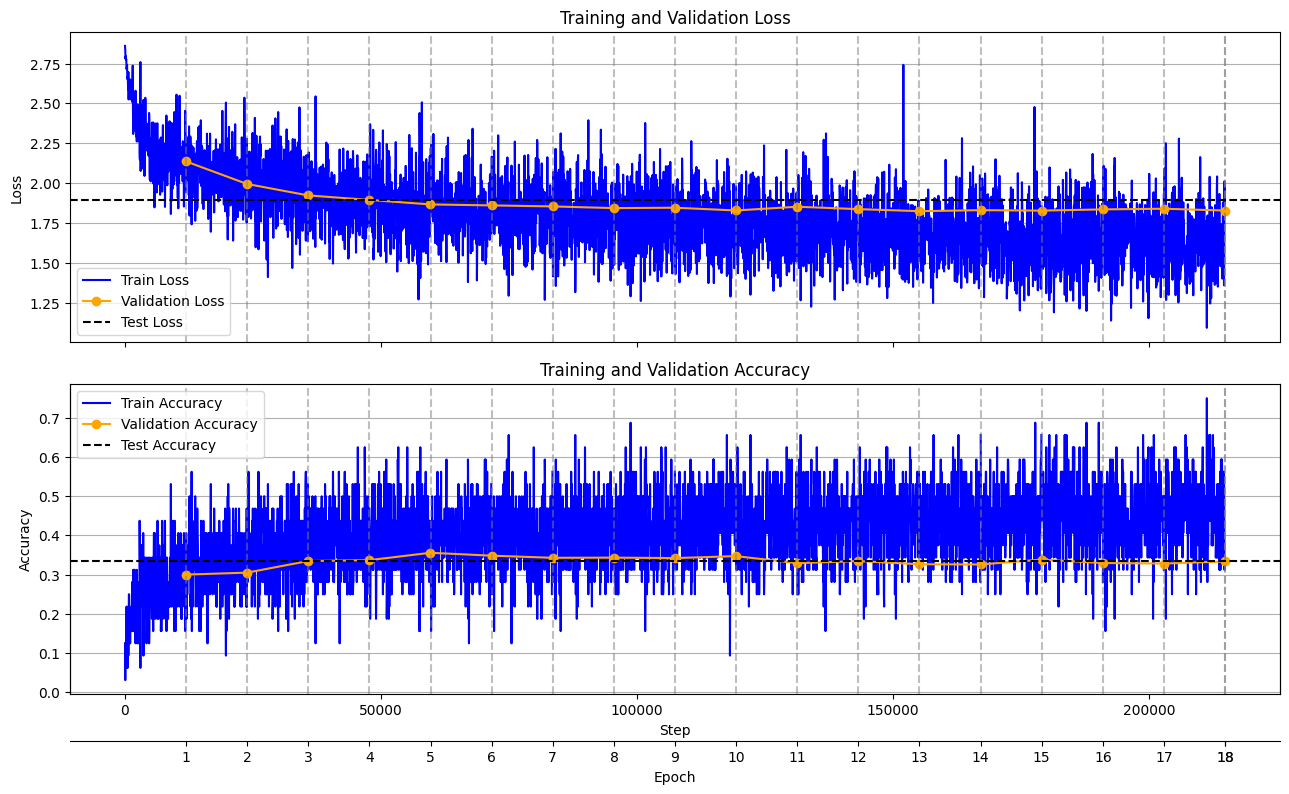

In [9]:
# Load the CSV
df = pd.read_csv("lightning_logs/version_0/metrics.csv")

# Convert columns to numeric safely
df["val_loss"] = pd.to_numeric(df["val_loss"], errors='coerce')
df["val_acc"] = pd.to_numeric(df["val_acc"], errors='coerce')
df["train_loss"] = pd.to_numeric(df["train_loss"], errors='coerce')
df["train_acc"] = pd.to_numeric(df["train_acc"], errors='coerce')

# Determine where epochs end
epoch_ends = df[df["epoch"].diff().fillna(0) > 0].index.tolist()
epoch_ends.append(len(df) - 1)  # Include last row as final step

# Epoch ticks and step positions
epoch_ticks = df.loc[epoch_ends, "step"].tolist()
epoch_labels = df.loc[epoch_ends, "epoch"].astype(int).tolist()

# Optional test metrics
test_loss = df["test_loss"].dropna().iloc[-1] if "test_loss" in df.columns else None
test_acc = df["test_acc"].dropna().iloc[-1] if "test_acc" in df.columns else None

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# Plot losses
ax1.plot(df["step"], df["train_loss"], label="Train Loss", color="blue")
ax1.plot(df["step"][df["val_loss"].notna()], df["val_loss"].dropna(), label="Validation Loss", color="orange", marker="o")

for idx in epoch_ends:
    ax1.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_loss is not None:
    ax1.axhline(y=test_loss, color='black', linestyle='--', label="Test Loss")

ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(axis='y')  # Only horizontal grid

# Plot accuracy
ax2.plot(df["step"], df["train_acc"], label="Train Accuracy", color="blue")
ax2.plot(df["step"][df["val_acc"].notna()], df["val_acc"].dropna(), label="Validation Accuracy", color="orange", marker="o")

for idx in epoch_ends:
    ax2.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_acc is not None:
    ax2.axhline(y=test_acc, color='black', linestyle='--', label="Test Accuracy")

ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Step")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(axis='y')  # Only horizontal grid

# Add secondary x-axis for epochs (at bottom)
ax2_epoch = ax2.twiny()
ax2_epoch.set_frame_on(True)
ax2_epoch.patch.set_visible(False)
ax2_epoch.xaxis.set_ticks_position("bottom")
ax2_epoch.xaxis.set_label_position("bottom")
ax2_epoch.spines["bottom"].set_position(("axes", -0.15))
ax2_epoch.spines["top"].set_visible(False)
ax2_epoch.set_xlim(ax2.get_xlim())
ax2_epoch.set_xticks(epoch_ticks)
ax2_epoch.set_xticklabels(epoch_labels)
ax2_epoch.set_xlabel("Epoch")

plt.tight_layout()
plt.show()


##### latent = 4

In [10]:
hidden_dim = 64
latent_dim = 4
model = EncoderMLPClassifier(
    num_features=len(feature_columns),
    latent_dim=latent_dim,
    hidden_dim=hidden_dim,
    num_classes=len(label_encoder.classes_),
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [11]:
MAX_EPOCHS = 50
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(model, train_loader, val_loader)
# Save the model
output_name = f"EMLP_h{hidden_dim}_l{latent_dim}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 1.5 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 48: 100%|██████████| 11933/11933 [08:56<00:00, 22.25it/s, v_num=1, train_loss=1.730, train_acc=0.438, val_loss=1.830, val_acc=0.393] 


In [12]:
model = EncoderMLPClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1399/1399 [00:46<00:00, 30.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.37100595235824585
        test_loss           1.9085445404052734
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.9085445404052734, 'test_acc': 0.37100595235824585}]

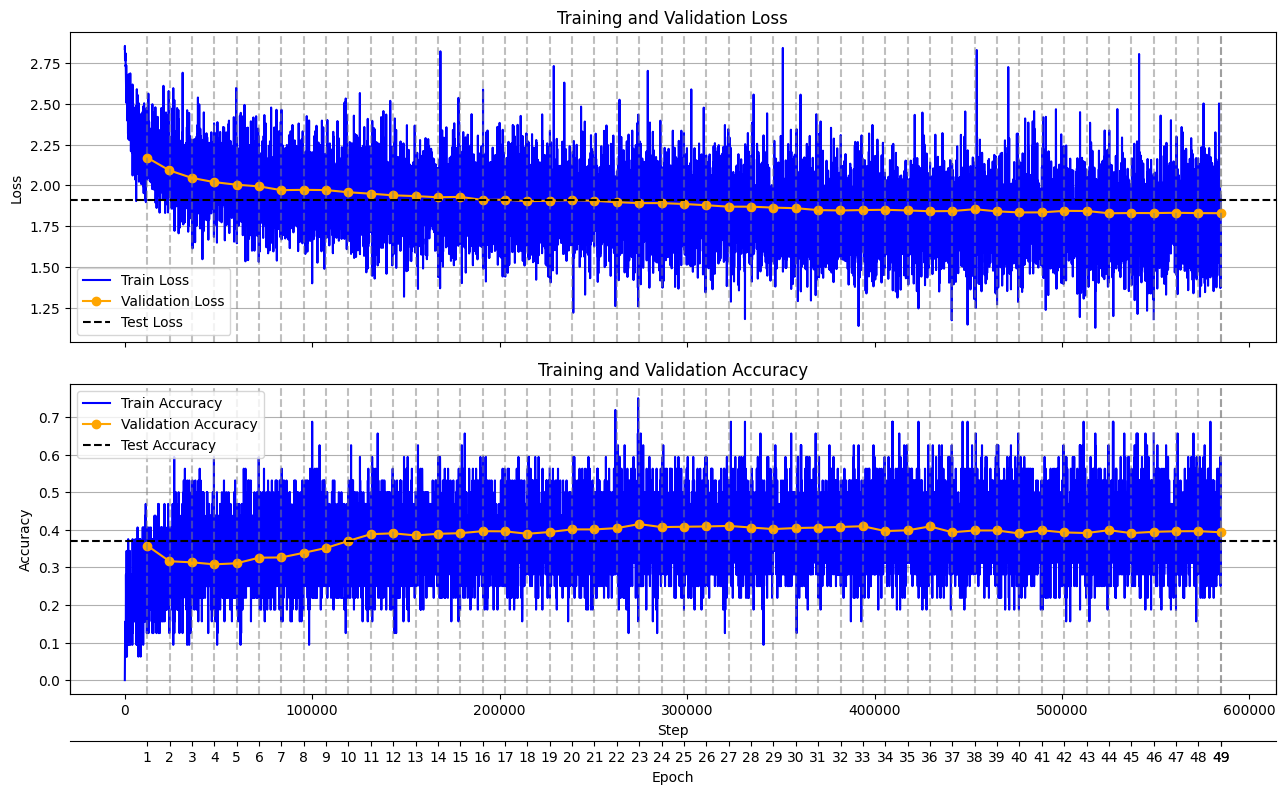

In [13]:
# Load the CSV
df = pd.read_csv("lightning_logs/version_1/metrics.csv")

# Convert columns to numeric safely
df["val_loss"] = pd.to_numeric(df["val_loss"], errors='coerce')
df["val_acc"] = pd.to_numeric(df["val_acc"], errors='coerce')
df["train_loss"] = pd.to_numeric(df["train_loss"], errors='coerce')
df["train_acc"] = pd.to_numeric(df["train_acc"], errors='coerce')

# Determine where epochs end
epoch_ends = df[df["epoch"].diff().fillna(0) > 0].index.tolist()
epoch_ends.append(len(df) - 1)  # Include last row as final step

# Epoch ticks and step positions
epoch_ticks = df.loc[epoch_ends, "step"].tolist()
epoch_labels = df.loc[epoch_ends, "epoch"].astype(int).tolist()

# Optional test metrics
test_loss = df["test_loss"].dropna().iloc[-1] if "test_loss" in df.columns else None
test_acc = df["test_acc"].dropna().iloc[-1] if "test_acc" in df.columns else None

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# Plot losses
ax1.plot(df["step"], df["train_loss"], label="Train Loss", color="blue")
ax1.plot(df["step"][df["val_loss"].notna()], df["val_loss"].dropna(), label="Validation Loss", color="orange", marker="o")

for idx in epoch_ends:
    ax1.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_loss is not None:
    ax1.axhline(y=test_loss, color='black', linestyle='--', label="Test Loss")

ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(axis='y')  # Only horizontal grid

# Plot accuracy
ax2.plot(df["step"], df["train_acc"], label="Train Accuracy", color="blue")
ax2.plot(df["step"][df["val_acc"].notna()], df["val_acc"].dropna(), label="Validation Accuracy", color="orange", marker="o")

for idx in epoch_ends:
    ax2.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_acc is not None:
    ax2.axhline(y=test_acc, color='black', linestyle='--', label="Test Accuracy")

ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Step")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(axis='y')  # Only horizontal grid

# Add secondary x-axis for epochs (at bottom)
ax2_epoch = ax2.twiny()
ax2_epoch.set_frame_on(True)
ax2_epoch.patch.set_visible(False)
ax2_epoch.xaxis.set_ticks_position("bottom")
ax2_epoch.xaxis.set_label_position("bottom")
ax2_epoch.spines["bottom"].set_position(("axes", -0.15))
ax2_epoch.spines["top"].set_visible(False)
ax2_epoch.set_xlim(ax2.get_xlim())
ax2_epoch.set_xticks(epoch_ticks)
ax2_epoch.set_xticklabels(epoch_labels)
ax2_epoch.set_xlabel("Epoch")

plt.tight_layout()
plt.show()


#### MLP

In [6]:
hidden_dim = 64
model = MLPClassifier(
    num_features=len(feature_columns),
    hidden_dim=hidden_dim,
    num_classes=len(label_encoder.classes_),
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [7]:
MAX_EPOCHS = 50
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1
)

trainer.fit(model, train_loader, val_loader)
# Save the model
output_name = f"MLP_h{hidden_dim}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 2.2 K  | train
1 | 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 11933/11933 [09:21<00:00, 21.27it/s, v_num=0, train_loss=0.949, train_acc=0.750, val_loss=1.170, val_acc=0.636]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 11933/11933 [09:21<00:00, 21.27it/s, v_num=0, train_loss=0.949, train_acc=0.750, val_loss=1.170, val_acc=0.636]


In [8]:
model = MLPClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1399/1399 [00:47<00:00, 29.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4701032340526581
        test_loss           1.7667090892791748
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.7667090892791748, 'test_acc': 0.4701032340526581}]

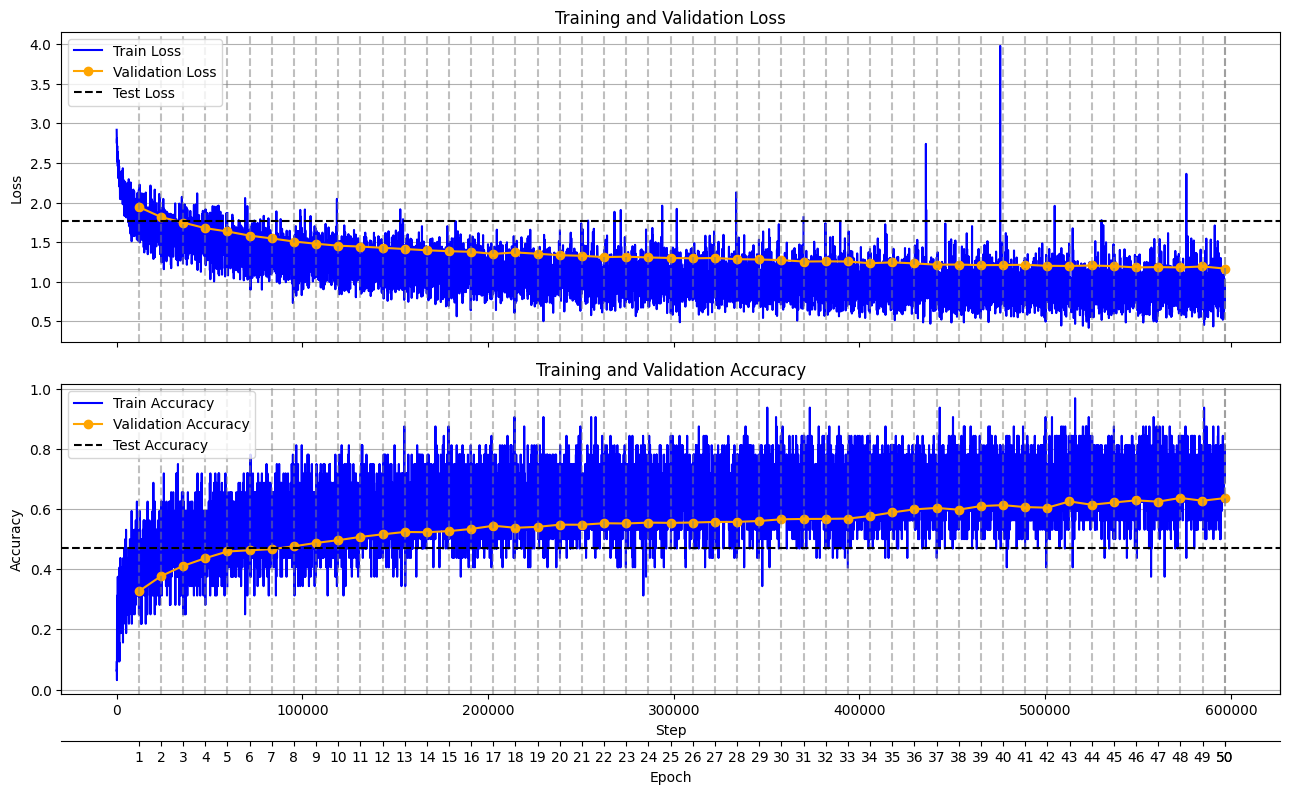

In [9]:
# Load the CSV
df = pd.read_csv("lightning_logs/version_0/metrics.csv")

# Convert columns to numeric safely
df["val_loss"] = pd.to_numeric(df["val_loss"], errors='coerce')
df["val_acc"] = pd.to_numeric(df["val_acc"], errors='coerce')
df["train_loss"] = pd.to_numeric(df["train_loss"], errors='coerce')
df["train_acc"] = pd.to_numeric(df["train_acc"], errors='coerce')

# Determine where epochs end
epoch_ends = df[df["epoch"].diff().fillna(0) > 0].index.tolist()
epoch_ends.append(len(df) - 1)  # Include last row as final step

# Epoch ticks and step positions
epoch_ticks = df.loc[epoch_ends, "step"].tolist()
epoch_labels = df.loc[epoch_ends, "epoch"].astype(int).tolist()

# Optional test metrics
test_loss = df["test_loss"].dropna().iloc[-1] if "test_loss" in df.columns else None
test_acc = df["test_acc"].dropna().iloc[-1] if "test_acc" in df.columns else None

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# Plot losses
ax1.plot(df["step"], df["train_loss"], label="Train Loss", color="blue")
ax1.plot(df["step"][df["val_loss"].notna()], df["val_loss"].dropna(), label="Validation Loss", color="orange", marker="o")

for idx in epoch_ends:
    ax1.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_loss is not None:
    ax1.axhline(y=test_loss, color='black', linestyle='--', label="Test Loss")

ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(axis='y')  # Only horizontal grid

# Plot accuracy
ax2.plot(df["step"], df["train_acc"], label="Train Accuracy", color="blue")
ax2.plot(df["step"][df["val_acc"].notna()], df["val_acc"].dropna(), label="Validation Accuracy", color="orange", marker="o")

for idx in epoch_ends:
    ax2.axvline(x=df.loc[idx, "step"], color='gray', linestyle='--', alpha=0.5)

if test_acc is not None:
    ax2.axhline(y=test_acc, color='black', linestyle='--', label="Test Accuracy")

ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Step")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(axis='y')  # Only horizontal grid

# Add secondary x-axis for epochs (at bottom)
ax2_epoch = ax2.twiny()
ax2_epoch.set_frame_on(True)
ax2_epoch.patch.set_visible(False)
ax2_epoch.xaxis.set_ticks_position("bottom")
ax2_epoch.xaxis.set_label_position("bottom")
ax2_epoch.spines["bottom"].set_position(("axes", -0.15))
ax2_epoch.spines["top"].set_visible(False)
ax2_epoch.set_xlim(ax2.get_xlim())
ax2_epoch.set_xticks(epoch_ticks)
ax2_epoch.set_xticklabels(epoch_labels)
ax2_epoch.set_xlabel("Epoch")

plt.tight_layout()
plt.show()
